# 准备工作

首先列出原始代码, 因为原始代码并不是c的形式, 所以这里手动列出所多面体所需要的各项信息:
```python
for i in range(1,1000):
  for j in range(1,500):
    a[i, j] = a[i, j+1] + b[i, j] # s1
    c[i, j] = a[i, j] + d[i+1, j] # s2
    d[i, j] = 3*e[i, j] # s3
```

In [2]:
import isl

In [3]:
domain = isl.union_set("{ s1[i, j] : 1 <= i < 1000 and 1 <= j < 500; s2[i, j] : 1 <= i < 1000 and 1 <= j < 500; s3[i, j] : 1 <= i < 1000 and 1 <= j < 500 }")
schedule = isl.union_map("{ s1[i,j] -> [t0 = i, t1 = j, t2 = 0]; s2[i,j] -> [t0 = i, t1 = j, t2 = 1]; s3[i,j] -> [t0 = i, t1 = j, t2 = 2] }")
reads = isl.union_map("{ s1[i,j] -> a[i,j+1]; s1[i,j] -> b[i,j]; s2[i, j] -> a[i,j]; s2[i, j] -> d[i+1,j]; s3[i, j] -> e[i,j];  }")
writes = isl.union_map("{ s1[i,j] -> a[i,j]; s2[i, j] -> c[i,j]; s3[i, j] -> d[i,j];  }")

In [4]:
print("domain:", domain)
print("schedule:", schedule)
print("reads:", reads)
print("writes:", writes)

domain: { s3[i, j] : 0 < i <= 999 and 0 < j <= 499; s2[i, j] : 0 < i <= 999 and 0 < j <= 499; s1[i, j] : 0 < i <= 999 and 0 < j <= 499 }
schedule: { s3[i, j] -> [t0 = i, t1 = j, t2 = 2]; s1[i, j] -> [t0 = i, t1 = j, t2 = 0]; s2[i, j] -> [t0 = i, t1 = j, t2 = 1] }
reads: { s1[i, j] -> b[i, j]; s3[i, j] -> e[i, j]; s1[i, j] -> a[i, 1 + j]; s2[i, j] -> a[i, j]; s2[i, j] -> d[1 + i, j] }
writes: { s2[i, j] -> c[i, j]; s3[i, j] -> d[i, j]; s1[i, j] -> a[i, j] }


# 依赖分析

## 写后读依赖

$$(R ^{-1} \circ W)\ \cap < S$$

Read After Write(RAW)依赖也被称为流依赖/真依赖, 需要保证前一个操作写入后才能进行正确读取, 对应计算机中常说的生产-消费关系. 也就是读语句作为`sink`节点, 写语句作为`source`节点, 我们可以用两种不同的api来计算写后读依赖.

In [5]:
raw = writes.apply_range(reads.reverse()).intersect(schedule.lex_lt_union_map(schedule))
print("read after write:",raw)

info = isl.union_access_info(reads)
info = info.set_must_source(writes)
info = info.set_schedule_map(schedule)
flow = info.compute_flow()
print("last write -> read", flow.full_must_dependence())

read after write: { s1[i, j] -> s2[i' = i, j' = j] }
last write -> read { s1[i, j] -> [s2[i' = i, j' = j] -> a[i, j]] }


在同一个`[i,j]`迭代下, `s1`对某个数据的写入后被`s2`读取.

## 读后写依赖

$$(W ^{-1} \circ R)\ \cap < S$$

Write After Read(WAR)依赖也被称为反依赖, 此时写语句作为`sink`节点, 读语句作为`source`节点.

In [6]:
war = reads.apply_range(writes.reverse()).intersect(schedule.lex_lt_union_map(schedule))
print("write after read:",war)

info = isl.union_access_info(writes)
info = info.set_must_source(reads)
info = info.set_schedule_map(schedule)
flow = info.compute_flow()
print("last read -> write", flow.full_must_dependence())

write after read: { s2[i, j] -> s3[i' = 1 + i, j' = j]; s1[i, j] -> s1[i' = i, j' = 1 + j] }
last read -> write { s2[i, j] -> [s3[i' = 1 + i, j' = j] -> d[1 + i, j]]; s1[i, j] -> [s1[i' = i, j' = 1 + j] -> a[i, 1 + j]] }


在`[i,j]`迭代中`s2`读取后, 在`[i+1,j]`迭代中`s3`中对同一位置进行覆盖写入. 在`[i,j]`迭代中`s1`读取后, 在`[i,j+1]`迭代中`s1`中对同一位置进行覆盖写入.

## 写后写依赖

$$(W ^{-1} \circ W)\ \cap < S$$

Write After Write也称为输出依赖, 此时最新的写入作为`sink`节点, 上一次写入作为`source`节点.


In [7]:
waw = writes.apply_range(writes.reverse()).intersect(schedule.lex_lt_union_map(schedule))
print("write after write:",waw)

info = isl.union_access_info(writes)
info = info.set_must_source(writes)
info = info.set_schedule_map(schedule)
flow = info.compute_flow()
print("last write -> current write", flow.full_must_dependence())

write after write: {  }
last write -> current write {  }


在数据流分析和依赖关系的上下文中, `sink`(汇点)和 `source`(源点)的概念是用来描述数据如何在不同的操作间流动的.依赖关系通常是从 `source` 到 `sink` 的, 这表示数据从 `source` 产生并流向 `sink`. 这个概念在不同类型的依赖中有所不同: 

1. 写后读(Write-After-Read, WAR)/ 真依赖(True Dependency): 
    - Source: 写操作, 因为它产生了数据.
    - Sink: 随后的读操作, 因为它使用了前面写操作产生的数据.
    - 依赖方向: 从写操作(source)到读操作(sink).
2. 读后写(Read-After-Write, RAW)/ 反依赖(Anti-dependency): 
    - Source: 读操作, 因为它首先访问了数据.
    - Sink: 随后的写操作, 因为它可能会改变前面读操作访问的数据.
    - 依赖方向: 从读操作(source)到写操作(sink).
3. 写后写(Write-After-Write, WAW)/ 输出依赖(Output Dependency): 
    - Source: 第一个写操作, 因为它首先写入数据.
    - Sink: 随后的写操作, 因为它写入相同的数据位置.
    - 依赖方向: 从第一个写操作(source)到第二个写操作(sink).

使用`union_access_info`计算出`union_flow`之后, 我们可以获取以下一些信息:

- must_dependence/full_must_dependence
- may_dependence/full_may_dependence
- must_no_source/may_no_source

这里带有`full`表示输出中带有对具体数组访问的信息.带有`may`前缀的表示无法确定的信息. 

这里`no_source`表示没有来源的实例, 比如例子中对于数组`c`只有写入没有读取, 例如在读后写依赖中,读作为`soure`, 这里的`no source`依赖为`{ s2[i, j] -> c[i, j] }`, 因为没有对数组`c`的写入只有对他的读取. 而对于写后读依赖, 这里的`no source`依赖为:`{ s1[i, j] -> b[i, j]; s3[i, j] -> e[i, j]; s2[i, j] -> d[1 + i, j]; s1[i, j] -> a[i, 1 + j] }`, 我们也可以称之为`live in memory`, 也就是在这段代码中只从外部读取的数据.

# 自动并行优化

通过观察依赖可以发现, 在这里存在了跨迭代的读后写依赖, 影响了这段代码的并行化. 因此我们需要考虑寻找合适的方法来消除这种依赖. 
在isl库中, 提供了`schedule_constraints`用于自动地构建和操作调度约束, 默认使用类似`pluto`的调度算法. 我们可以给他提供迭代域, `validity`(有效性依赖, 用于保证程序正确性), `proximity`(临近性依赖, 用于提升局部性), `coincidence`(相干性依赖, 用于提示并行性). 

然后使用`compute_schedule`函数可以用来计算满足给定调度约束的调度. 这些调度约束包括计算调度所需的迭代域以及迭代对之间的依赖. 生成的调度将遵守所有有效性依赖，确保这些依赖在调度空间中的依赖距离是字典序上的正值​​. 

In [8]:
sc = isl.schedule_constraints.on_domain(domain)
dep = war.union(raw).union(waw)
sc = sc.set_validity(dep)
sc = sc.set_coincidence(dep)
sc = sc.set_proximity(dep)
sched = sc.compute_schedule()
print(sched.root())

# YOU ARE HERE
domain: "{ s3[i, j] : 0 < i <= 999 and 0 < j <= 499; s2[i, j] : 0 < i <= 999 and 0 < j <= 499; s1[i, j] : 0 < i <= 999 and 0 < j <= 499 }"
child:
  schedule: "[{ s3[i, j] -> [(i)]; s2[i, j] -> [(1 + i)]; s1[i, j] -> [(1 + i)] }, { s3[i, j] -> [(j)]; s2[i, j] -> [(j)]; s1[i, j] -> [(j)] }]"
  permutable: 1
  coincident: [ 1, 0 ]
  child:
    sequence:
    - filter: "{ s1[i, j] }"
    - filter: "{ s2[i, j] }"
    - filter: "{ s3[i, j] }"



这里我们需要利用`band`节点的coincident信息在后续codegen是生成带有并行的代码, 但是在isl中内置的循环类型只有`isl_ast_loop_default,isl_ast_loop_atomic,isl_ast_loop_unroll,isl_ast_loop_separate`这四种, 并且都是会在codegen时有单独的处理, 所以我们只能自己添加`mark`节点到图上, 给后续使用. 

In [9]:
def insert_mark_before_bind(node: isl.schedule_node) -> isl.schedule_node:
    if (isinstance(node, isl.schedule_node_band)):
        bind: isl.schedule_node_band = node
        splited_bind = None
        new_bind = bind
        while True:
            splited = False
            for i in range(new_bind.n_member()):
                if (new_bind.member_get_coincident(i)):
                    new_bind = new_bind.split(i+1)
                    new_bind = new_bind.insert_mark(isl.id(f"parallel"))
                    if splited_bind is None:
                        splited_bind = new_bind
                    new_bind = new_bind.child(0).child(0)
                    splited = True
                    break
            if (not splited):
                break

        return bind if splited_bind is None else splited_bind
    return node


# post order visit
new_sched = sched.map_schedule_node_bottom_up(insert_mark_before_bind)

In [10]:
new_sched.root()

isl.schedule_node_domain("""# YOU ARE HERE
domain: "{ s3[i, j] : 0 < i <= 999 and 0 < j <= 499; s2[i, j] : 0 < i <= 999 and 0 < j <= 499; s1[i, j] : 0 < i <= 999 and 0 < j <= 499 }"
child:
  mark: "parallel"
  child:
    schedule: "[{ s3[i, j] -> [(i)]; s2[i, j] -> [(1 + i)]; s1[i, j] -> [(1 + i)] }]"
    permutable: 1
    coincident: [ 1 ]
    child:
      schedule: "[{ s3[i, j] -> [(j)]; s2[i, j] -> [(j)]; s1[i, j] -> [(j)] }]"
      permutable: 1
      child:
        sequence:
        - filter: "{ s1[i, j] }"
        - filter: "{ s2[i, j] }"
        - filter: "{ s3[i, j] }"
""")

对于添加`mark`节点后的调度树, 首先我们将他转换为`ast tree`:

In [11]:
def after_mark_callback(node: isl.ast_node_mark, build: isl.ast_build) -> isl.ast_node:
    if (node.id().name() == "parallel"):
      mark_child: isl.ast_node  = node.node()
      mark_child = mark_child.set_annotation(isl.id("parallel"))
      # NOTE isl内部应该有bug,如果root节点为ast for, 那么后续遍历时无法遍历到root for ast node. 所以这里手动添加一个block
      return isl.ast_node_block(isl.ast_node_list(isl.ast_node(mark_child))) 
    return node


builder = isl.ast_build()
builder = builder.set_after_each_mark(after_mark_callback)
tree: isl.ast_node = builder.node_from(new_sched)

接下来需要处理两个事情, 一个是statement的表达式生成, 另一个就是并行循环生成, 这里都使用`callback`来处理:

In [12]:
from common import CSource


def print_for_callback(p: isl.printer, opt: isl.ast_print_options, node: isl.ast_node_for):
    anno = node.get_annotation()
    if (anno.ptr is not None and anno.name() == "parallel"):
        p.start_line()
        p.print_str("#pragma omp parallel for")
        p.end_line()
    node.print(p, opt)
    return p


def print_user_callback(p: isl.printer, opt: isl.ast_print_options, node: isl.ast_node_user):
    e = node.expr()
    if isinstance(e, isl.ast_expr_op_call):
        sid: isl.ast_expr_id = e.arg(0)
        i, j = e.arg(1), e.arg(2)
        idname = sid.id().name()
        if (idname == "s1"):
            # a[i, j] = a[i, j+1] + b[i, j] # s1
            a = isl.ast_expr.from_id(isl.id("a"))
            b = isl.ast_expr.from_id(isl.id("b"))
            l = isl.ast_expr_list(2)
            l = l.add(i)
            l = l.add(j.add(isl.ast_expr.from_val(isl.val(1))))
            lhs = isl.ast_expr.access(a, l)
            
            l = isl.ast_expr_list(2)
            l = l.add(i)
            l = l.add(j)
            rhs = isl.ast_expr.access(b, l)

            left = lhs.add(rhs)

            l = isl.ast_expr_list(2)
            l = l.add(i)
            l = l.add(j)
            right = isl.ast_expr.access(a, l)
            p.start_line()
            p.print_ast_expr(right)
            p.print_str(" = ")
            p.print_ast_expr(left)
            p.print_str(";")
            p.end_line()
        elif idname == "s2":
            # c[i, j] = a[i, j] + d[i+1, j] # s2
            a = isl.ast_expr.from_id(isl.id("a"))
            c = isl.ast_expr.from_id(isl.id("c"))
            d = isl.ast_expr.from_id(isl.id("d"))
            ij = isl.ast_expr_list(2)
            ij = ij.add(i)
            ij = ij.add(j)
            
            i1j = isl.ast_expr_list(2)
            i1j = i1j.add(i.add(isl.ast_expr.from_val(isl.val(1))))
            i1j = i1j.add(j)
            p.start_line()
            p.print_ast_expr(c.access(ij))
            p.print_str(" = ")
            p.print_ast_expr(a.access(ij).add(d.access(i1j)))
            p.print_str(";")
            p.end_line()
        elif idname == "s3":
            # d[i, j] = 3*e[i, j] # s3
            d = isl.ast_expr.from_id(isl.id("d"))
            e = isl.ast_expr.from_id(isl.id("e"))
            ij = isl.ast_expr_list(2)
            ij = ij.add(i)
            ij = ij.add(j)
            
            p.start_line()
            p.print_ast_expr(d.access(ij))
            p.print_str(" = ")
            p.print_ast_expr(isl.ast_expr.from_val(3).mul(e.access(ij)))
            p.print_str(";")
            p.end_line()
    return p


printer = isl.printer.from_file('/tmp/1.c')
printer.set_output_format(isl.ISL_FORMAT.C)

options = isl.ast_print_options.alloc()
options = options.set_print_for(print_for_callback)
options = options.set_print_user(print_user_callback)
tree.print(printer, options)
printer.flush()

CSource('/tmp/1.c')

```c
{
  #pragma omp parallel for
  for (int c0 = 1; c0 <= 1000; c0 += 1)
    for (int c1 = 1; c1 <= 499; c1 += 1) {
      if (c0 >= 2) {
        a[c0 - 1][c1] = a[c0 - 1][c1 + 1] + b[c0 - 1][c1];
        c[c0 - 1][c1] = a[c0 - 1][c1] + d[c0 - 1 + 1][c1];
      }
      if (c0 <= 999)
        d[c0][c1] = 3 * e[c0][c1];
    }
}

```

# 手动并行优化

我们需要考虑哪些依赖是跨迭代的, 通过消除跨迭代的依赖性来进行并行化. 首先我们选取迭代域的子集绘制两个写后读依赖图:

In [13]:
import petplot.plotter as plt

{ s1[i, j] -> s1[i' = i, j' = 1 + j] : 0 < i <= 9 and 0 < j <= 4 }


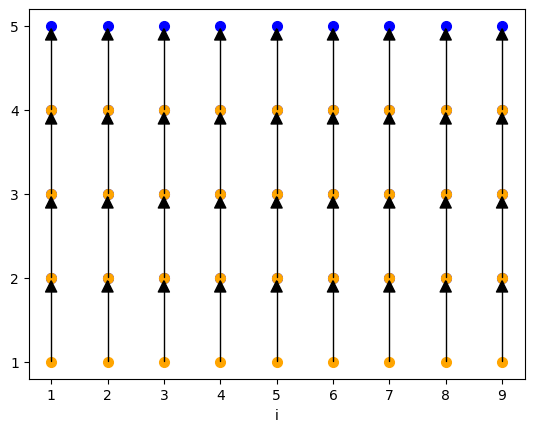

In [14]:
partial_domain = isl.set("{s1[i, j] : 1 <= i < 10 and 1 <= j < 5 }")
s1 = war.map_list().at(1)
s1_point_map = s1.intersect_domain(partial_domain)
print(s1_point_map)
plt.plot_map(s1_point_map)

{ s2[i, j] -> s3[i' = 1 + i, j' = j] : 0 < i <= 9 and 0 < j <= 4 }


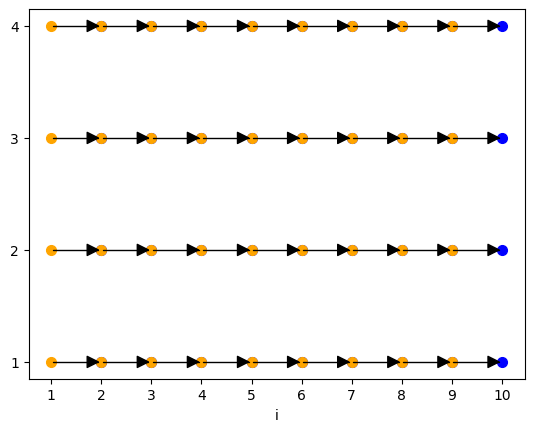

In [15]:
partial_domain = isl.set("{s2[i, j] : 1 <= i < 10 and 1 <= j < 5 }")
s2 = war.map_list().at(0)
s2_point_map = s2.intersect_domain(partial_domain)
print(s2_point_map)
plt.plot_map(s2_point_map)

上图表示在迭代`i`上, `s1`不存在跨迭代依赖. 在迭代`j`上`s2`并不存在跨迭代依赖. 那么说明我们可以考虑对迭代`i`或`j`中进行并行可能性. 迭代`i`在迭代`j`的外部, 如果对迭代`i`进行并行, `s2`上存在跨迭代的依赖会导致错误. 

注意到迭代`j`中只有`s1`存在依赖, 而其他两个语句不存在依赖, 那么我们可以通过`Loop Fission`拆分迭代`j`的语句, 单独对`s2,s3`的进行并行化.

接下来我们手动构造一个拆分后的调度树:

In [39]:
sched2 = isl.schedule.from_domain(domain)
root = sched2.root()
c0 =  root.child(0).insert_partial_schedule(isl.multi_union_pw_aff("[{ s3[i, j] -> [(i)]; s2[i, j] -> [(i)]; s1[i, j] -> [(i)] }]"))
c1 = c0.child(0).insert_sequence(isl.union_set_list("({ s1[i, j] }, { s2[i, j]; s3[i, j] })"))
c2 = c1.child(0).child(0).insert_partial_schedule(isl.multi_union_pw_aff("[{ s1[i, j] -> [j] }]"))
c2 = c2.child(0).insert_sequence(isl.union_set_list("({ s1[i, j] })"))

In [40]:
c3 = c2.parent().parent().parent().child(1).child(0).insert_mark(isl.id("parallel")).child(0).insert_partial_schedule(isl.multi_union_pw_aff("[{ s3[i, j] -> [j]; s2[i, j] -> [j] }]"))
c3 = c3.child(0).insert_sequence(isl.union_set_list("({ s2[i, j] }, { s3[i, j] })"))
c3

isl.schedule_node_sequence("""domain: "{ s3[i, j] : 0 < i <= 999 and 0 < j <= 499; s2[i, j] : 0 < i <= 999 and 0 < j <= 499; s1[i, j] : 0 < i <= 999 and 0 < j <= 499 }"
child:
  schedule: "[{ s2[i, j] -> [(i)]; s1[i, j] -> [(i)]; s3[i, j] -> [(i)] }]"
  child:
    sequence:
    - filter: "{ s1[i, j] }"
      child:
        schedule: "[{ s1[i, j] -> [(j)] }]"
        child:
          sequence:
          - filter: "{ s1[i, j] }"
    - filter: "{ s3[i, j]; s2[i, j] }"
      child:
        mark: "parallel"
        child:
          schedule: "[{ s3[i, j] -> [(j)]; s2[i, j] -> [(j)] }]"
          child:
            # YOU ARE HERE
            sequence:
            - filter: "{ s2[i, j] }"
            - filter: "{ s3[i, j] }"
""")

对调度树进行代码生成:

In [41]:
new_sched = c3.schedule()
builder = isl.ast_build()
builder = builder.set_after_each_mark(after_mark_callback)
tree: isl.ast_node = builder.node_from(new_sched)
printer = isl.printer.from_file('/tmp/2.c')
printer.set_output_format(isl.ISL_FORMAT.C)

options = isl.ast_print_options.alloc()
options = options.set_print_for(print_for_callback)
options = options.set_print_user(print_user_callback)
tree.print(printer, options)
printer.flush()

CSource('/tmp/2.c')

```c
for (int c0 = 1; c0 <= 999; c0 += 1) {
  for (int c1 = 1; c1 <= 499; c1 += 1)
    a[c0][c1] = a[c0][c1 + 1] + b[c0][c1];
  #pragma omp parallel for
  for (int c1 = 1; c1 <= 499; c1 += 1) {
    c[c0][c1] = a[c0][c1] + d[c0 + 1][c1];
    d[c0][c1] = 3 * e[c0][c1];
  }
}

```